In [1]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
from librosa import core, onset, feature, display
import soundfile as sf
# import umap
from IPython.display import Audio
import sklearn

In [2]:
df = pd.read_csv("data/birdsong_metadata.csv")
df.head()

,file_id,genus,species,english_cname,who_provided_recording,country,latitude,longitute,type,license
0,132608,Acanthis,flammea,Common Redpoll,Jarek Matusiak,Poland,50.7932,15.4995,"female, male, song",http://creativecommons.org/licenses/by-nc-sa/3.0/
1,132611,Acanthis,flammea,Common Redpoll,Jarek Matusiak,Poland,50.7932,15.4995,"flight call, male, song",http://creativecommons.org/licenses/by-nc-sa/3.0/
2,35068,Acanthis,flammea,Common Redpoll,Sander Bot,Netherlands,52.8176,6.4326,"call, song",http://creativecommons.org/licenses/by-nc-nd/2.5/
3,82715,Acrocephalus,palustris,Marsh Warbler,Dougie Preston,United Kingdom,60.3539,-1.2689,Song,http://creativecommons.org/licenses/by-nc-nd/2.5/
4,64685,Acrocephalus,palustris,Marsh Warbler,Dougie Preston,United Kingdom,60.3539,-1.2689,Song,http://creativecommons.org/licenses/by-nc-nd/2.5/


In [3]:
def load_audio(file_id):
    data, samplerate = sf.read("data/songs/xc"+str(file_id)+".flac")
    s = len(data)/samplerate
    sg = feature.melspectrogram(y = data, sr=samplerate, hop_length=512)

    # Take mean amplitude M from frame with highest energy
    centerpoint = np.argmax(sg.mean(axis=0))
    M = sg[:,centerpoint].mean()

    # Filter out all frames with energy less than 5% of M
    mask = sg.mean(axis=0)>=M/20

    audio_mask = np.zeros(len(data), dtype=bool)
    for i in range(0,len(mask)):
        audio_mask[i*512:] = mask[i]
    return sg, mask, data, audio_mask, samplerate

In [4]:
df['length'] = np.zeros(len(df))

waves = {}


for file_id in df['file_id']:
    print(file_id)
    sg, mask, data, audio_mask, sample_rate = load_audio(file_id)
    waves[file_id] = data[audio_mask]
    df.loc[df['file_id'] == file_id,'length'] = len(data[audio_mask])
    #print(len(data[audio_mask])/sample_rate)

132608
132611
35068
82715
64685
64686
120664
120666
76767
124052
124053
27999
113082
101371
128853
123169
123170
158166
138979
30614
142431
83705
33395
99299
139552
67307
77645
94584
35578
95381
64738
118363
83894
156388
67229
27039
133880
97792
133886
70129
130409
146753
28961
99155
124013
129576
129577
143894
121691
156262
121735
92264
116226
121677
89994
82971
77429
130993
94614
94615
42224
143170
64735
96464
98400
96133
27145
143002
143005
33392
37447
134671
42178
44203
131316
148465
133444
142697
148528
98172
72629
130426
98942
155975
123168
125777
123167
102106
102107
145533
102048
102803
86327
70124
30390
133862
42803
122548
121597
31059
44707
130639
27080
90977
135270
89530
26789
82701
127136
142908
46223
58571
58573
58579
53817
25754
76241
157322
157331
157279
108002
133054
133471
130283
149806
71943
126481
154285
125486
102060
125782
145534
83760
140557
110303
94211
94212
99862
123808
123810
132580
148426
141026
97194
125137
41428
118441
69792
102788
36637
103145
134042
13937

In [5]:
df['windows'] = df['length'].apply(lambda x: int(x/6.144000e+03))
df.head()

,file_id,genus,species,english_cname,who_provided_recording,country,latitude,longitute,type,license,length,windows
0,132608,Acanthis,flammea,Common Redpoll,Jarek Matusiak,Poland,50.7932,15.4995,"female, male, song",http://creativecommons.org/licenses/by-nc-sa/3.0/,256512.0,41
1,132611,Acanthis,flammea,Common Redpoll,Jarek Matusiak,Poland,50.7932,15.4995,"flight call, male, song",http://creativecommons.org/licenses/by-nc-sa/3.0/,52736.0,8
2,35068,Acanthis,flammea,Common Redpoll,Sander Bot,Netherlands,52.8176,6.4326,"call, song",http://creativecommons.org/licenses/by-nc-nd/2.5/,47104.0,7
3,82715,Acrocephalus,palustris,Marsh Warbler,Dougie Preston,United Kingdom,60.3539,-1.2689,Song,http://creativecommons.org/licenses/by-nc-nd/2.5/,152576.0,24
4,64685,Acrocephalus,palustris,Marsh Warbler,Dougie Preston,United Kingdom,60.3539,-1.2689,Song,http://creativecommons.org/licenses/by-nc-nd/2.5/,94720.0,15


In [6]:
n_windows = df.groupby('species')['windows'].sum().min()
n_windows

20

In [7]:
windows = {}

for file_id in df['file_id']:
    wave = waves[file_id]
    species = df[df['file_id']==file_id]['genus'].values[0] + "_" + df[df['file_id']==file_id]['species'].values[0]
    if species not in windows:
        windows[species] = []
    for i in range(0, int(len(wave)/6.144000e+03)):
        windows[species].append(wave[i:int(i+6.144000e+03)])

In [8]:
windows_fixed = {}
windows_fixed_test = {}

for species in windows.keys():
    windows_fixed[species] = []
    windows_fixed_test[species] = []
    ws = windows[species]
    index = np.random.choice(len(ws), n_windows, replace=False)
    for i in range(0, len(ws)):
        if i in index:
            windows_fixed[species].append(ws[i])
        else:
            windows_fixed_test[species].append(ws[i])

In [9]:
# Extract Features from Window
new_dataset = pd.DataFrame()

for species in windows_fixed.keys():
    for i in range(0,n_windows):
        data_point = {'species':species.split('_')[1], 'genus':species.split('_')[0]}
        spec_centroid = feature.spectral_centroid(y = windows_fixed[species][i])[0]
        chroma = feature.chroma_stft(y = windows_fixed[species][i], sr = sample_rate)
        #print(data_point)
        for j in range(0,13):
            #print(spec_centroid[j], j)
            data_point['spec_centr_'+str(j)] = spec_centroid[j]
            for k in range(0,12):
                data_point['chromogram_'+str(k)+"_"+str(j)] = chroma[k,j]
        #print(111)
        new_dataset = new_dataset._append(data_point,ignore_index=True)
        #print(111)
new_dataset.head()

C:\Anaconda\lib\site-packages\librosa\core\pitch.py:101: UserWarning: Trying to estimate tuning from empty frequency set.
  return pitch_tuning(
C:\Anaconda\lib\site-packages\librosa\core\pitch.py:101: UserWarning: Trying to estimate tuning from empty frequency set.
  return pitch_tuning(
C:\Anaconda\lib\site-packages\librosa\core\pitch.py:101: UserWarning: Trying to estimate tuning from empty frequency set.
  return pitch_tuning(
C:\Anaconda\lib\site-packages\librosa\core\pitch.py:101: UserWarning: Trying to estimate tuning from empty frequency set.
  return pitch_tuning(
C:\Anaconda\lib\site-packages\librosa\core\pitch.py:101: UserWarning: Trying to estimate tuning from empty frequency set.
  return pitch_tuning(
C:\Anaconda\lib\site-packages\librosa\core\pitch.py:101: UserWarning: Trying to estimate tuning from empty frequency set.
  return pitch_tuning(
C:\Anaconda\lib\site-packages\librosa\core\pitch.py:101: UserWarning: Trying to estimate tuning from empty frequency set.
  return

,species,genus,spec_centr_0,chromogram_0_0,chromogram_1_0,chromogram_2_0,chromogram_3_0,chromogram_4_0,chromogram_5_0,chromogram_6_0,...,chromogram_2_12,chromogram_3_12,chromogram_4_12,chromogram_5_12,chromogram_6_12,chromogram_7_12,chromogram_8_12,chromogram_9_12,chromogram_10_12,chromogram_11_12
0,flammea,Acanthis,2442.089677,0.645542,0.349450,0.166184,0.096049,0.093169,0.073407,0.034041,...,0.412498,0.243003,0.112923,0.046037,0.028564,0.061722,0.129256,0.452654,1.000000,0.714536
1,flammea,Acanthis,2441.397755,1.000000,0.620250,0.318581,0.151816,0.094349,0.094949,0.069267,...,0.553780,0.390659,0.218012,0.100694,0.040641,0.028188,0.067299,0.145260,0.510484,1.000000
2,flammea,Acanthis,2443.366373,1.000000,0.620077,0.318395,0.151747,0.094501,0.095324,0.069563,...,0.552913,0.389868,0.217546,0.100458,0.040529,0.028066,0.066965,0.145106,0.510679,1.000000
3,flammea,Acanthis,2439.988776,1.000000,0.621762,0.320039,0.152444,0.095059,0.096328,0.070788,...,0.551704,0.388921,0.217786,0.100475,0.040764,0.027681,0.065430,0.142715,0.506232,1.000000
4,flammea,Acanthis,2442.625813,1.000000,0.621600,0.319911,0.152382,0.095194,0.096708,0.071108,...,0.550812,0.388119,0.217357,0.100262,0.040622,0.027560,0.065099,0.142576,0.506416,1.000000


In [10]:
# Extract Features from Window for test
new_dataset_test = pd.DataFrame()

for species in windows_fixed_test.keys():
    for i in range(0,len(windows_fixed_test[species])):
        data_point = {'species':species.split('_')[1], 'genus':species.split('_')[0]}
        spec_centroid = feature.spectral_centroid(y = windows_fixed_test[species][i])[0]
        chroma = feature.chroma_stft(y = windows_fixed_test[species][i], sr = sample_rate)
        for j in range(0,13):
            data_point['spec_centr_'+str(j)] = spec_centroid[j]
            for k in range(0,12):
                data_point['chromogram_'+str(k)+"_"+str(j)] = chroma[k,j]
        new_dataset_test = new_dataset_test._append(data_point,ignore_index=True)

new_dataset_test.head()

C:\Anaconda\lib\site-packages\librosa\core\pitch.py:101: UserWarning: Trying to estimate tuning from empty frequency set.
  return pitch_tuning(
C:\Anaconda\lib\site-packages\librosa\core\pitch.py:101: UserWarning: Trying to estimate tuning from empty frequency set.
  return pitch_tuning(
C:\Anaconda\lib\site-packages\librosa\core\pitch.py:101: UserWarning: Trying to estimate tuning from empty frequency set.
  return pitch_tuning(
C:\Anaconda\lib\site-packages\librosa\core\pitch.py:101: UserWarning: Trying to estimate tuning from empty frequency set.
  return pitch_tuning(
C:\Anaconda\lib\site-packages\librosa\core\pitch.py:101: UserWarning: Trying to estimate tuning from empty frequency set.
  return pitch_tuning(
C:\Anaconda\lib\site-packages\librosa\core\pitch.py:101: UserWarning: Trying to estimate tuning from empty frequency set.
  return pitch_tuning(
C:\Anaconda\lib\site-packages\librosa\core\pitch.py:101: UserWarning: Trying to estimate tuning from empty frequency set.
  return

,species,genus,spec_centr_0,chromogram_0_0,chromogram_1_0,chromogram_2_0,chromogram_3_0,chromogram_4_0,chromogram_5_0,chromogram_6_0,...,chromogram_2_12,chromogram_3_12,chromogram_4_12,chromogram_5_12,chromogram_6_12,chromogram_7_12,chromogram_8_12,chromogram_9_12,chromogram_10_12,chromogram_11_12
0,flammea,Acanthis,2439.945547,0.645315,0.349250,0.166102,0.096156,0.093512,0.073729,0.034165,...,0.411641,0.242523,0.112759,0.045962,0.028441,0.061449,0.128977,0.452955,1.000000,0.714293
1,flammea,Acanthis,2443.446204,1.000000,0.620579,0.318997,0.151927,0.094071,0.094180,0.068650,...,0.555383,0.392124,0.218584,0.100603,0.040804,0.028532,0.067722,0.145757,0.509797,1.000000
2,flammea,Acanthis,2440.628987,1.000000,0.620424,0.318773,0.151869,0.094209,0.094567,0.068958,...,0.554592,0.391417,0.218344,0.100698,0.040755,0.028357,0.067543,0.145454,0.510272,1.000000
3,flammea,Acanthis,2440.042293,1.000000,0.622055,0.320582,0.152584,0.094716,0.095581,0.070223,...,0.553241,0.390372,0.218837,0.101043,0.040824,0.027893,0.066034,0.143134,0.505659,1.000000
4,flammea,Acanthis,2444.563339,1.000000,0.621917,0.320325,0.152506,0.094887,0.095952,0.070502,...,0.552449,0.389643,0.218332,0.100761,0.040778,0.027789,0.065724,0.142933,0.505951,1.000000


In [11]:
X_train = new_dataset.drop(['species', 'genus'], axis=1)
y_train = new_dataset['species']

X_test = new_dataset_test.drop(['species', 'genus'], axis=1)
y_test = new_dataset_test['species']

# Naive Bayes as Stand-Alone

Accuracy: 0.9299290268254541
F1 Score: 0.9382210691197505


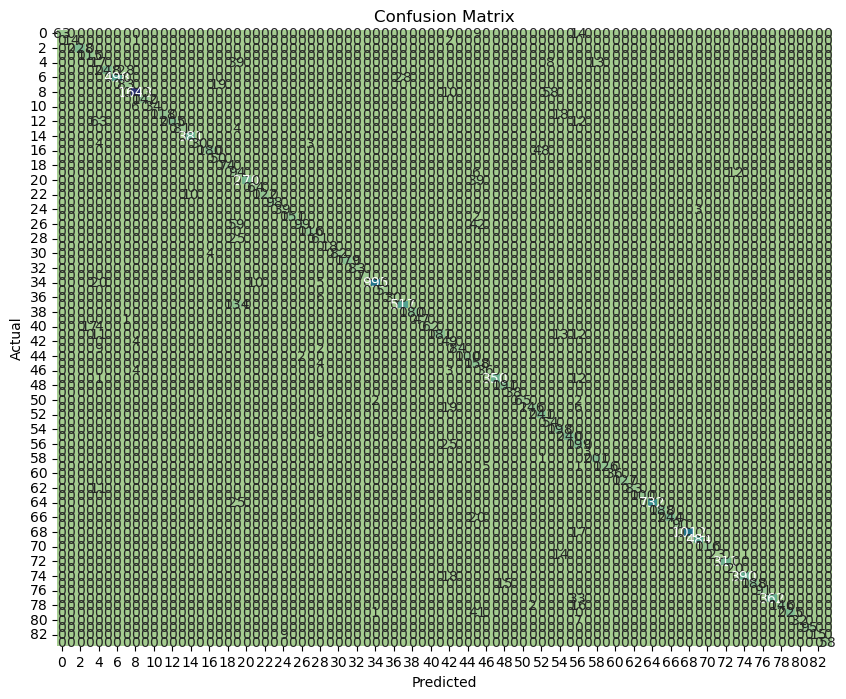

In [12]:
from sklearn.naive_bayes import GaussianNB
from sklearn.metrics import confusion_matrix, accuracy_score, f1_score 
import seaborn as sns

# Initialize and train the Naive Bayes classifier
clf = GaussianNB()
clf.fit(X_train, y_train)

# Predict on the test set
y_pred = clf.predict(X_test)

# Evaluate the classifier
accuracy = accuracy_score(y_test, y_pred)
f1 = f1_score(y_test, y_pred, average='weighted')

print("Accuracy:", accuracy)
print("F1 Score:", f1)

# Generate confusion matrix
cm = confusion_matrix(y_test, y_pred)
plt.figure(figsize=(10, 8))
sns.heatmap(cm, annot=True, fmt='g', cmap='crest', cbar=False)
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.title('Confusion Matrix')
plt.show()

# Naive Bayes Nearest Neighbors

In [13]:
from sklearn.pipeline import make_pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.naive_bayes import GaussianNB
from sklearn.neighbors import KNeighborsClassifier
from sklearn.ensemble import VotingClassifier
from sklearn.metrics import accuracy_score, f1_score

# Initialize classifiers
nb_clf = GaussianNB()
knn_clf = KNeighborsClassifier()

# Create a voting classifier
voting_clf = VotingClassifier(estimators=[('nb', nb_clf), ('knn', knn_clf)], voting='soft')

# Create a pipeline with StandardScaler and VotingClassifier
clf = make_pipeline(StandardScaler(), voting_clf)

# Train the model
clf.fit(X_train, y_train)

# Predict on the test set
y_pred = clf.predict(X_test)

# Calculate accuracy and F1-score
accuracy = accuracy_score(y_test, y_pred)
f1 = f1_score(y_test, y_pred, average='weighted')

print("Accuracy:", accuracy)
print("F1 Score:", f1)

Accuracy: 0.9376278118609407
F1 Score: 0.9457627585202282


# Naive Bayes SVM

In [14]:
from sklearn.pipeline import make_pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.svm import SVC
from sklearn.naive_bayes import GaussianNB
from sklearn.ensemble import VotingClassifier
from sklearn.metrics import accuracy_score, f1_score

# Initialize classifiers
nb_clf = GaussianNB()
svm_clf = SVC(probability=True)  # Note: Set probability=True for SVC to enable probability estimates

# Create a voting classifier
voting_clf = VotingClassifier(estimators=[('nb', nb_clf), ('svm', svm_clf)], voting='soft')

# Create a pipeline with StandardScaler and VotingClassifier
clf = make_pipeline(StandardScaler(), voting_clf)

# Train the model
clf.fit(X_train, y_train)

# Predict on the test set
y_pred = clf.predict(X_test)

# Calculate accuracy and F1-score
accuracy = accuracy_score(y_test, y_pred)
f1 = f1_score(y_test, y_pred, average='weighted')

print("Accuracy:", accuracy)
print("F1 Score:", f1)

Accuracy: 0.9271021291952364
F1 Score: 0.9377647297167004
